In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
req = requests.get('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3')
csv = pd.read_csv(StringIO(req.text), delimiter=';', parse_dates=['jour'])
csv


,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0
...,...,...,...,...,...,...,...
68701,94,59,2021-02-27,5,0,91,6
68702,94,69,2021-02-27,11,1,113,17
68703,94,79,2021-02-27,24,6,136,37
68704,94,89,2021-02-27,31,1,123,55


### *per region withe age == 0*

In [2]:
REGIONS={
    1:["IDF", 12_213_447], 
    11:["IDF", 12_213_447], 
    2: ["Centre", 2_572_853],
    24: ["Centre", 2_572_853],
    27: ["Bourgogne-Franche Comté", 2_807_807],
    28: ["Normandie", 3_499_280],
    3: ["Nord", 4_050_756],
    32: ["Nord", 6_004_108],
    4: ["Grand Est", 5_550_389],
    44: ["Grand Est", 5_550_389],
    52: ["Pays de Loire", 3_781_423],
    53: ["Bretagne", 3_335_414],
    75: ["Nouvelle Acquitaine", 5_879_778],
    76: ["Occitanie", 5_885_496],
    84: ["Auvergne", 7_994_459],
    93: ["Provence Côte d'Azur", 5_052_832],
    94: ["Corse", 338_554]
    }
df=csv[csv['cl_age90'] == 0].drop(columns=['rad', 'rea', 'hosp', 'cl_age90'])\
    .groupby(['jour', 'reg'])\
    .sum()\
    .unstack('reg')\
    .stack(level=0)\
    .groupby({k:v[0] for k,v in REGIONS.items()}, axis=1).sum()
s=df.sum()
df=df.diff()
df.index
df=df[s.sort_values(ascending=False).index]
df.index=df.index.get_level_values(0)
df.index
    #.clip(0).rolling(10).median()\
    #.plot.area(stacked=True, figsize=(18,8))

DatetimeIndex(['2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27',
               ...
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27'],
              dtype='datetime64[ns]', name='jour', length=347, freq=None)

In [4]:
import pandas as pd 

# data in the form of list of tuples 
data = [ 
('Age', [18, 15, 17, 18, 17]), 
('Team', ['A', 'B', 'A', 'C', 'B']), 
('Score', [7, 6, 8, 7, 5]), 
] 

pd.DataFrame?


Init signature:
pd.DataFrame(
    data=None,
    index: Union[Collection, NoneType] = None,
    columns: Union[Collection, NoneType] = None,
    dtype: Union[ForwardRef('ExtensionDtype'), str, numpy.dtype, Type[Union[str, float, int, complex, bool]], NoneType] = None,
    copy: bool = False,
)
Docstring:     
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, or list-like objects.

    .. versionchanged:: 0.23.0
       If data is a dict, column order follows insertion-order for
       Python 3.6 and later.

    .. versionchanged:: 0.25.0
       If data is a list of dicts, column order follows insertion-order


### *same but but doing the sum of ages*

In [5]:
r=csv[csv['cl_age90'] == 0].drop(columns=['rad', 'rea', 'hosp', 'cl_age90'])\
    .groupby(['jour', 'reg'])\
    .sum()\
    .unstack('reg')\
    .sum(axis=1)\
    .diff()
r[r==r.max()]

jour
2020-04-06    605.0
dtype: float64

In [6]:
csv[csv['cl_age90'] > 0].drop(columns=['rad', 'rea', 'hosp'])\
    .groupby(['jour',  'cl_age90', 'reg'])\
    .sum()\
    .unstack('reg')\
    .sum(axis=1)\
    .unstack('cl_age90')\
    .diff()\
    #.groupby({9:0, 19:0, 29:0, 39:0, 49:0, 59:1, 69:2, 79:3, 89:4, 90:4}, axis=1).sum()\
    #.clip(0).rolling(10).median()\
    #.rename(columns={1: '50 à 59 ans', 2: '60 à 69 ans', 3: '70 à 79 ans', 0: 'Moins de 50 ans', 4: 'Plus de 80 ans'})\
    #.plot.area(stacked=True, figsize=(18,8))

cl_age90,9,19,29,39,49,59,69,79,89,90
jour,,,,,,,,,,
2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-19,0.0,0.0,1.0,0.0,1.0,6.0,16.0,36.0,72.0,18.0
2020-03-20,0.0,0.0,-1.0,0.0,0.0,2.0,6.0,24.0,37.0,10.0
2020-03-21,0.0,0.0,0.0,0.0,0.0,4.0,11.0,30.0,46.0,19.0
2020-03-22,0.0,0.0,0.0,1.0,3.0,0.0,15.0,28.0,42.0,23.0
...,...,...,...,...,...,...,...,...,...,...
2021-02-23,0.0,0.0,1.0,1.0,1.0,11.0,28.0,69.0,119.0,77.0
2021-02-24,0.0,0.0,0.0,1.0,3.0,7.0,31.0,72.0,102.0,59.0
2021-02-25,0.0,0.0,0.0,0.0,2.0,6.0,28.0,73.0,102.0,49.0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
req = requests.get('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3')
csv = pd.read_csv(StringIO(req.text), delimiter=';', parse_dates=['jour'])

def group_cols(df, cols, gn):
    s = df[cols[0]]
    for c in cols[1:]:
        s = s + df[c]
    df[gn] = s
    return df.drop(columns=cols)

def filter(csv, col):
    dropped = ['dc', 'rad', 'rea', 'hosp']
    dropped.remove(col)
    temp = csv[csv['reg'] != 0].groupby(['jour', 'reg', 'cl_age90']).\
        sum().\
        drop(columns=dropped).\
        unstack('cl_age90').\
        groupby('jour').\
        sum()
    temp.columns = [x for _, x in temp.columns]
    temp = group_cols(temp, [9, 19, 29, 39, 49], 0)
    temp = group_cols(temp, [89, 90], 99)
    temp = temp.reindex(sorted(temp.columns), axis=1)
    temp.columns = ['Moins de 50 ans', '50 à 59 ans',
                    '60 à 69 ans', '70 à 79 ans', 'plus de 80 ans']
    return temp
df.index=df.index.get_level_values(0)

req = requests.get('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3')
csv = pd.read_csv(StringIO(req.text), delimiter=';', parse_dates=['jour'])

In [9]:
REGIONS={plt.savefig(dest + 'covid-hosp-par-region-pondere.png')

plot_par_region("Réanimations par région", 'rea')
plt.savefig(dest + 'covid-rea-par-region.png')
plot_par_region("Réanimations par région relatifs à la population ", 'rea', pond=True, inline=True)
plt.savefig(dest + 'covid-rea-par-region-pondere.png')

smooth = 3
plot_par_region(f"Décès par région - Lissage {smooth}j ", 'dc', smooth=smooth)
plt.savefig(dest + 'covid-deces-par-region.png')
plot_par_region(f"Décès par région relatifs à la population - Lissage {smooth}j ", 'dc', pond=True, smooth=smooth, inline=True)
plt.savefig(dest + 'covid-deces-par-region-pondere.png')

plt.show()
    11:["IDF", 12_213_447], 
    24: ["Centre-Val de Loire", 2_572_853],
    27: ["Bourgogne-Franche Comté", 2_807_807],
    28: ["Normandie", 3_499_280],
    3: ["Nord Pas de Calais", 4_050_756],
    32: ["Hauts de France", 6_004_108],
    44: ["Grand Est", 5_550_389],
    52: ["Pays de Loire", 3_781_423],
    53: ["Bretagne", 3_335_414],
    75: ["Nouvelle Acquitaine", 5_879_778],
    76: ["Occitanie", 5_885_496],
    84: ["Auvergne", 7_994_459],
    93: ["Provence Côte d'Azur", 5_052_832],
    94: ["Corse", 338_554]
    }
# regions to be grouped together
MIX =[(2, 24), (1,11), (4, 44), (6, 75)]

reg = pd.DataFrame(REGIONS, index=['nom','population']).T
population = int(reg.population.sum())
print(f"Population totale = {population}")

def plot_par_region(title, col)df.index=df.index.get_level_values(0)
:
    df = csv[csv['cl_age90'] == 0][['jour', 'reg', col]]
    df = df.pivot(index='jour', columns='reg')
    if col == 'dc':
        df = df.diff().rolling(10).mean().clip(0)

    # group some region together
    df.set_axis([y for x, y in df.columns], axis=1, inplace=True)
    for c1, c2 in MIX:
        df[c2] = df[c2]+df[c1]
        df = df.drop(columns=[c1])

    # rename the columns
    # correct relative to the population (disabled)
    df.set_axis([REGIONS.get(y, [str(y)])[0] for y in df.columns], axis=1, inplace=True)
    for c in df.columns:df.index=df.index.get_level_values(0)

        try:
            pop = reg.population[reg.nom==c].values[0]
            #print(c, reg.population[reg.nom==c].values)
        except Exception as err:
            pop=1
            #print(df.tail(1))
        #print(c, pop)
        #df[c] = df[c].astype(float).divide(pop).multiply(population)

    s=df.sum()
    df=df[s.sort_values(ascending=False).index[:10]]
    df.plot.area(figsize=(20,8), title=title)

plot_par_region("Hospitalisations", 'hosp')
plot_par_region("Réanimations", 'df.index=df.index.get_level_values(0)', 'rea')
plot_par_region("Décès (lissé sur 10j)", 'dc')


SyntaxError: invalid syntax (<ipython-input-9-115b116c8698>, line 24)

Population totale = 64915840


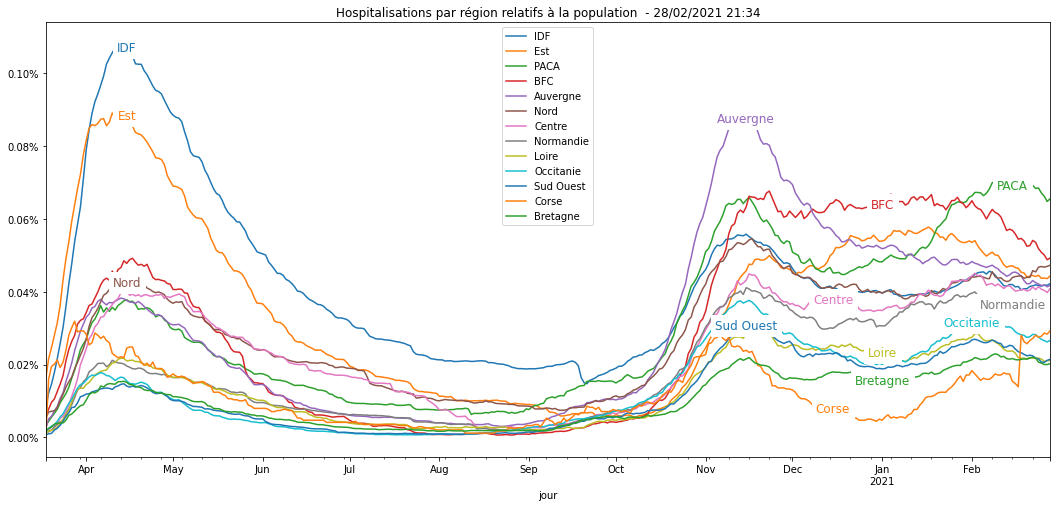

In [36]:
import datetime
from labellines import labelLine, labelLines
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import pandas as pd
import requests
from io import StringIO

req = requests.get('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3')
csv = pd.read_csv(StringIO(req.text), delimiter=';', parse_dates=['jour'])

REGIONS = {
    1: ["IDF", 12_213_447],
    11: ["IDF", 12_213_447],
    2: ["Centre", 2_572_853],
    24: ["Centre", 2_572_853],
    27: ["BFC", 2_807_807],
    28: ["Normandie", 3_499_280],
    3: ["Nord", 4_050_756],
    32: ["Nord", 6_004_108],
    4: ["Est", 5_550_389],
    44: ["Est", 5_550_389],
    52: ["Loire", 3_781_423],
    53: ["Bretagne", 3_335_414],
    75: ["Sud Ouest", 5_879_778],
    76: ["Occitanie", 5_885_496],
    84: ["Auvergne", 7_994_459],
    93: ["PACA", 5_052_832],
    94: ["Corse", 338_554]
}
pop = {r:v for r,v in REGIONS.values()}
population = sum(pop.values())

print(f"Population totale = {population}")

def plot_par_region(title, col, pond=False, smooth=1, inline=False):
    dropped = ['dc', 'rad', 'rea', 'hosp', 'cl_age90']
    dropped.remove(col)
    df = csv[csv['cl_age90'] == 0]\
        .drop(columns=dropped)\
        .groupby(['jour', 'reg'])\
        .sum()\
        .unstack('reg')\
        .stack(level=0)

    # group and rename the columns
    df = df.groupby({k: v[0] for k, v in REGIONS.items()}, axis=1).sum()
    if pond:
        for c in df.columns:
            df[c] = df[c].divide(pop.get(c, 1))

    s = df.sum()
    if col == 'dc':
        df = df.diff()
    df = df[s.sort_values(ascending=False).index]
    df.index = df.index.get_level_values(0)
    now= datetime.datetime.today().strftime("%d/%m/%Y %H:%M")
    if pond:
        p = df.clip(0).rolling(smooth).mean()\
            .plot(figsize=(18, 8), title=title+f' - {now}')
        p.yaxis.set_major_formatter(
            FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        if inline:
            xvals=  [
                date2num(datetime.date(2020, 4, 15)),   # IDF
                date2num(datetime.date(2020, 4, 15)),   # Est 
                date2num(datetime.date(2021, 2, 15)),   # PACA 
                date2num(datetime.date(2021,  1, 1)),   # BFC 
                date2num(datetime.date(2020, 11, 15)),  # Auvergne 
                date2num(datetime.date(2020, 4, 15)),   # Nord 
                date2num(datetime.date(2020, 12, 15)),  # Centre 
                date2num(datetime.date(2021, 2, 15)),   # Normandie 
                date2num(datetime.date(2021, 1, 1)),    # Loire 
                date2num(datetime.date(2021, 2, 1)),   # Occitanie
                date2num(datetime.date(2020, 11, 15)),   # Sud Ouest 
                date2num(datetime.date(2020, 12, 15)),   # Bretagne
                date2num(datetime.date(2021, 1, 1)),   # Corse 
                ]
            labelLines(plt.gca().get_lines(), xvals=xvals, align=False, fontsize=12)
    else:
        df.clip(0).rolling(smooth).mean()\
            .plot.area(stacked=True, figsize=(18, 8), title=title+f' - {now}')


plot_par_region("Hospitalisations par région relatifs à la population ",
                'hosp', pond=True, inline=True)

